## Bayesian Optimisation Verification

In [3]:
# import relevant packages
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel, Matern
from sklearn.metrics import mean_squared_error
from itertools import product
from gp_para import gp_tuning
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# stop showing warning messages
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [4]:
# Seed for reproducibility
rng = np.random.default_rng(12345)

In [5]:
### Impot data for training and evaluation
# import data sheet (time:0~5000s) with temp 120, 140, 160, 180
address = 'data/degradation.xlsx'
y_normal = np.empty(shape=[0,1])
i = 3
list_temp = (120,140,160,180)
for temp in list_temp:
    df = pd.read_excel(address,sheet_name = 'normal data',usecols = [i],names = None,nrows = 5000)
    df = df.values.tolist()
    df = np.array(df)
    y_normal =  np.append(y_normal,df)
    i+=1

In [38]:
### Data setup 
# NUM_OF_DATA_POINTS must be an even number
NUM_OF_DATA_POINTS = 20
NUM_OF_PLOT_POINTS = 100
### Kernel setting and prediction
LOWEST_NOISE_LEVEL = 1e-16
HIGHEST_NOISE_LEVEL = 1e-12
KERNEL_ALPHA = 1e-15

# choosing data selection mode. See comments for what each mode does.
data_partition_mode = 3

# Mode 1: Data setup with half points evenly spread in 0-999, another half in 1000-4999
if data_partition_mode == 1:
    X_num = np.hstack([np.linspace(0,999,num=int(3*NUM_OF_DATA_POINTS/4),dtype=int),
                       np.linspace(1000,4999,num=int(NUM_OF_DATA_POINTS/4),dtype=int)])

# Mode 2: Data setup with1/4 in 0-199, 2/4 in 200-999, 1/4 1000-4999
elif data_partition_mode == 2:
    X_num = np.hstack([ np.linspace(0,199,num=int(NUM_OF_DATA_POINTS/4),dtype=int),
                    np.linspace(200,999,num=int(NUM_OF_DATA_POINTS/2),dtype=int),
                    np.linspace(1000,4999,num=int(NUM_OF_DATA_POINTS/4),dtype=int)])

# Mode 3: Data setup with 2/5 in 0-99, 2/5 in 100-999, 1/5 1000-4999
elif data_partition_mode == 3: 
    X_num = np.hstack([ np.linspace(0,99,num=int(NUM_OF_DATA_POINTS*2/5),dtype=int),
                    np.linspace(199,999,num=int(NUM_OF_DATA_POINTS*2/5),dtype=int),
                    np.linspace(1000,4999,num=int(NUM_OF_DATA_POINTS*1/5),dtype=int)])

# Mode 4: Data setup with  points evenly spread 
elif data_partition_mode == 4:
    X_num = np.linspace(0,4999,num=int(NUM_OF_DATA_POINTS),dtype=int)

# Mode 5: Data setup with points spread in log space
else:
    X_num = np.logspace(0,np.log10(4999), num=NUM_OF_DATA_POINTS, base=10.0, dtype=int)
    HIGHEST_NOISE_LEVEL = 1e-15
    KERNEL_ALPHA = 8e-5



In [39]:
X_ = np.arange(0,5000).astype(int)
x_normal = np.empty(shape=[0,2])
temp_list = np.array([120,140,160,180])

for temp in temp_list:
    df_temp = np.full((5000,1),temp)
    x_normal_partial = np.hstack([X_.reshape(5000,1),df_temp])
    x_normal =  np.concatenate([x_normal,x_normal_partial])

Y = y_normal[np.hstack([X_num,X_num+5000,X_num+5000*2,X_num+5000*3])]
X = np.empty(shape=[0,2])
for temp in temp_list:
    df_temp = np.full((int(NUM_OF_DATA_POINTS),1),temp)
    X_partial = np.hstack([X_num.reshape(int(NUM_OF_DATA_POINTS),1),df_temp])
    X = np.concatenate([X, X_partial])

In [40]:
# Scoring metrics 
def weighted_mean_sq_error(estimator, x, y):
    y_pred = estimator.predict(x)
    # more weight for points with x<1000
    weight = np.where(x[:,0]<1000,0.75,0.25)
    weighted_sq = weight*(np.square(y - y_pred))
    return -weighted_sq.mean()

def error_lowest_pt(estimator, x, y):
    # error for the smallest point
    y_pred = estimator.predict(x)
    position = np.argmin(y)
    return -abs(y[position]-y_pred[position])

# Defining search space
alpha_space = np.logspace(-8, -5, 7)
length_scale_space = np.arange(3,4,0.01)
length_scale_space = np.append(length_scale_space,[2.35,0.27,4.24,6.17,17,0.32]) # starting from 0.32 num_data = 100
alpha_space = np.append(alpha_space,3e-7)

param_space = {'alpha': np.logspace(-8, -5, 7),
                   'kernel': [1.0 * RBF(length_scale = i,length_scale_bounds=[0,1e5]) 
                                + WhiteKernel(noise_level=1e-16,noise_level_bounds=(1e-15,1e-11)) for i in length_scale_space]
                                + [1.0 * Matern(length_scale = i,length_scale_bounds=[0,1e5]) 
                                + WhiteKernel(noise_level=1e-16,noise_level_bounds=(1e-15,1e-11)) for i in length_scale_space]}

# Performing grid search
gp = GaussianProcessRegressor()
gp_search = GridSearchCV(gp, param_space,
                             scoring={"weighted_mean_squared_error": weighted_mean_sq_error,
                                      "log_marginal_likelihood": lambda estimator, x,
                                                                        y: estimator.log_marginal_likelihood_value_,
                                      "error_lowest_point": error_lowest_pt},            
                             refit = "log_marginal_likelihood"
                             )
gp_search.fit(X,Y)
print(gp_search)

GridSearchCV(estimator=GaussianProcessRegressor(),
             param_grid={'alpha': array([1.00000000e-08, 3.16227766e-08, 1.00000000e-07, 3.16227766e-07,
       1.00000000e-06, 3.16227766e-06, 1.00000000e-05]),
                         'kernel': [1**2 * RBF(length_scale=3) + WhiteKernel(noise_level=1e-16),
                                    1**2 * RBF(length_scale=3.01) + WhiteKernel(noise_level=1e-16),
                                    1**2 * RBF(length_scale=3.02) + WhiteKernel(n...
                                    1**2 * RBF(length_scale=3.28) + WhiteKernel(noise_level=1e-16),
                                    1**2 * RBF(length_scale=3.29) + WhiteKernel(noise_level=1e-16), ...]},
             refit='log_marginal_likelihood',
             scoring={'error_lowest_point': <function error_lowest_pt at 0x000002675460E040>,
                      'log_marginal_likelihood': <function <lambda> at 0x0000026754663EE0>,
                      'weighted_mean_squared_error': <function wei

In [41]:
# ranking models by three different metrics
models = pd.DataFrame(gp_search.cv_results_)[['param_kernel',
                              'param_alpha', 'rank_test_weighted_mean_squared_error',
                              'rank_test_log_marginal_likelihood',
                              'rank_test_error_lowest_point']].sort_values(by="rank_test_weighted_mean_squared_error")
models["rank"] = models["rank_test_weighted_mean_squared_error"]+models["rank_test_log_marginal_likelihood"
                                                                       ]+models["rank_test_error_lowest_point"]
models.sort_values(by="rank", inplace=True)
print(models.iloc[1,:])
models

param_kernel                             1**2 * RBF(length_scale=3.42) + WhiteKernel(no...
param_alpha                                                                       0.000003
rank_test_weighted_mean_squared_error                                                  163
rank_test_log_marginal_likelihood                                                       18
rank_test_error_lowest_point                                                             1
rank                                                                                   182
Name: 1102, dtype: object


,param_kernel,param_alpha,rank_test_weighted_mean_squared_error,rank_test_log_marginal_likelihood,rank_test_error_lowest_point,rank
1147,1**2 * RBF(length_scale=3.87) + WhiteKernel(no...,0.000003,145,6,31,182
1102,1**2 * RBF(length_scale=3.42) + WhiteKernel(no...,0.000003,163,18,1,182
1118,1**2 * RBF(length_scale=3.58) + WhiteKernel(no...,0.000003,112,4,73,189
1110,1**2 * RBF(length_scale=3.5) + WhiteKernel(noi...,0.000003,121,46,27,194
1123,1**2 * RBF(length_scale=3.63) + WhiteKernel(no...,0.000003,159,28,7,194
...,...,...,...,...,...,...
606,"1**2 * Matern(length_scale=3.76, nu=1.5) + Whi...",0.0,1480,1480,1480,4440
405,"1**2 * Matern(length_scale=3.87, nu=1.5) + Whi...",0.0,1481,1481,1481,4443
414,"1**2 * Matern(length_scale=3.96, nu=1.5) + Whi...",0.0,1482,1482,1482,4446
590,"1**2 * Matern(length_scale=3.6, nu=1.5) + Whit...",0.0,1483,1483,1483,4449


In [42]:
# The best model
gp = GaussianProcessRegressor(alpha=0.000003 ,kernel = 1**2 * RBF(length_scale=3.42) + WhiteKernel(noise_level=1e-16))
#2.35,0.27,4.24,6.17,17,0.32 (length scale parameters that can be considered)
gp.fit(X,Y)
print(gp)

GaussianProcessRegressor(alpha=3e-06,
                         kernel=1**2 * RBF(length_scale=3.42) + WhiteKernel(noise_level=1e-16))


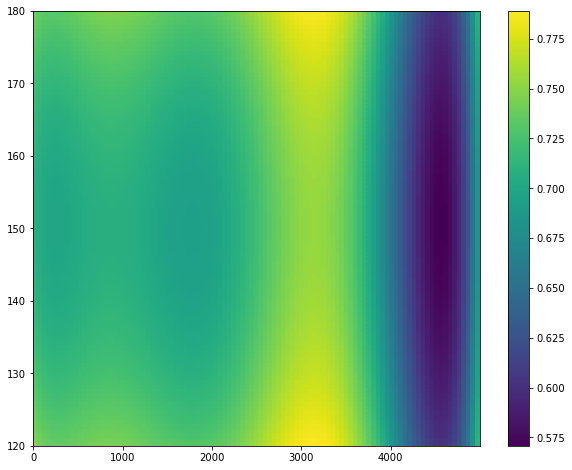

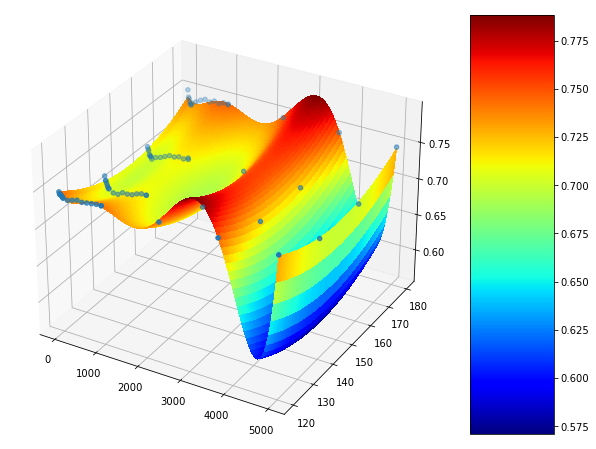

In [43]:
# plotting the surface
x1 = np.linspace(X[:,0].min(), X[:,0].max(),num = NUM_OF_PLOT_POINTS)
x2 = np.linspace(X[:,1].min(), X[:,1].max(),num = NUM_OF_PLOT_POINTS)
x1x2 = np.array(list(product(x1, x2)))
y_pred, MSE = gp.predict(x1x2, return_std=True)
X0p, X1p = x1x2[:,0].reshape(NUM_OF_PLOT_POINTS,NUM_OF_PLOT_POINTS), x1x2[:,1].reshape(NUM_OF_PLOT_POINTS,NUM_OF_PLOT_POINTS)
Zp = np.reshape(y_pred,(NUM_OF_PLOT_POINTS,NUM_OF_PLOT_POINTS))

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
pcm = ax.pcolormesh(X0p, X1p, Zp)
fig.colorbar(pcm, ax=ax)
plt.show()

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')            
surf = ax.plot_surface(X0p, X1p, Zp, rstride=1, cstride=1, cmap='jet', linewidth=0, antialiased=False)
ax.scatter(X[:,0],X[:,1],Y)
fig.colorbar(surf, aspect=5)
plt.show()


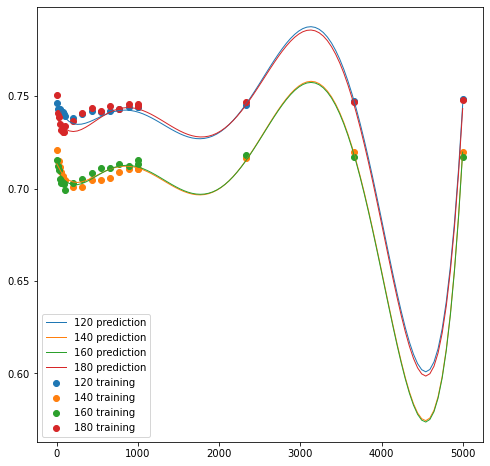

In [44]:
# Training and prediction results for different temperatures
fig = plt.figure(figsize=(8,8))
i = 1
for temp in temp_list:
    plt.plot(x1,Zp[:,i],label = str(temp)+' prediction',lw=1)
    i += int(NUM_OF_PLOT_POINTS/3-1)
j = NUM_OF_DATA_POINTS
for temp in temp_list:
    plt.scatter (X_num,Y[j-NUM_OF_DATA_POINTS:j],label = str(temp)+' training')
    j += NUM_OF_DATA_POINTS
plt.legend()
plt.show()

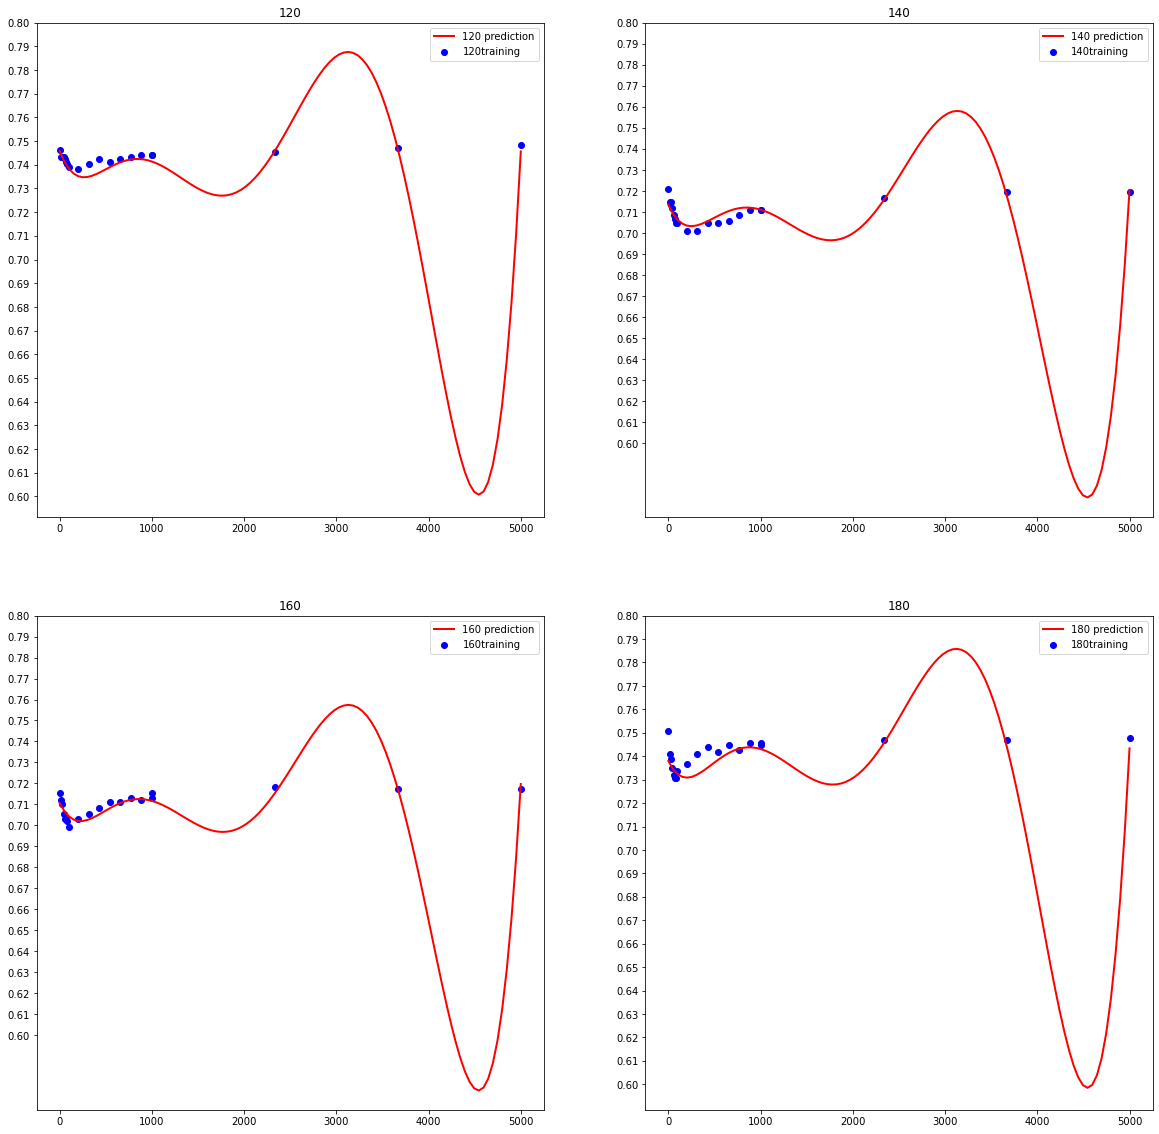

In [45]:
# results for different temperatures
i = 1
j = NUM_OF_DATA_POINTS
k = 0
fig = plt.figure(figsize=(20,20))
plot_index = 1
for temp in temp_list:
    plt.subplot(2,2,plot_index),plt.plot(x1,Zp[:,i],label = str(temp)+' prediction',c='red',lw=2,zorder=3),
    plt.scatter (X_num,Y[j-NUM_OF_DATA_POINTS:j],label = str(temp)+'training',c='blue',zorder=2),
#     plt.scatter(X_,y_normal[k:k+5000],label = str(temp)+' true',s=1,c='grey',zorder=1),
    plt.yticks(np.arange(0.6,0.8,0.01)),plt.title(str(temp)),plt.legend(),plt.tight_layout

    i += int(NUM_OF_PLOT_POINTS/3-1)
    j += NUM_OF_DATA_POINTS
    k+=5000
    plot_index+=1
plt.show()